# XGBoost, LightGBM Ensemble

### [1. Feature Engineering](#Feature-Engineering)
### [2. Prepare Traing and Test Data](#Prepare-Training-and-Test-Data)
### [3. Modeling](#Modeling)
### [4. Submission](#Submission)
### [5. References](#References)

**Public score is 0.03958**

In [1]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import gc

%matplotlib inline

# Feature Engineering

In [2]:
MTeams = pd.read_csv('input/MDataFiles_Stage1/MTeams.csv')
MSeasons = pd.read_csv('input/MDataFiles_Stage1/MSeasons.csv')
MRegularSeasonDetailedResults = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
MNCAATourneyDetailedResults = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
MNCAATourneySeeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
MRegularSeasonCompactResults = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
MNCAATourneyCompactResults = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
MNCAATourneySeeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
MNCAATourneySeeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')

In [3]:
MNCAATourneySeeds['Seed'] = MNCAATourneySeeds['Seed'].apply(lambda x: int(x[1:3]))

In [4]:
season_win = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore']]
season_win.rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'}, inplace=True)
season_lose = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore']]
season_lose.rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'}, inplace=True)
season_df = pd.concat((season_win, season_lose)).reset_index(drop=True)
season_df = season_df.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_df

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Season,TeamID,Score
0,1985,1102,1514
1,1985,1103,1404
2,1985,1104,2055
3,1985,1106,1719
4,1985,1108,2075
...,...,...,...
11236,2019,1462,2372
11237,2019,1463,2265
11238,2019,1464,2205
11239,2019,1465,1962


In [5]:
MNCAATourneyCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [6]:
# Merge MNCAATourneyCompactResults and MNCAATourneySeeds
train = pd.merge(MNCAATourneyCompactResults[['Season', 'WTeamID', 'LTeamID']],
              MNCAATourneySeeds,
              how='left',
              left_on=['Season', 'WTeamID'],
              right_on=['Season', 'TeamID'])
train.rename(columns={'Seed': 'WSeed'}, inplace=True)
train.drop(['TeamID'], axis=1, inplace=True)
train = pd.merge(train, MNCAATourneySeeds,
                 how='left',
                left_on=['Season','LTeamID'],
                right_on=['Season', 'TeamID'])
train.rename(columns={'Seed': 'LSeed'}, inplace=True)
train.drop('TeamID', axis=1, inplace=True)
train.head()

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14


In [7]:
train = pd.merge(train, season_df, how='left',
                left_on=['Season', 'WTeamID'],
                right_on=['Season', 'TeamID'])
train.rename(columns={'Score': 'WScoreSum'}, inplace=True)
train.drop('TeamID', axis=1, inplace=True)

train = pd.merge(train, season_df, how='left',
                left_on=['Season', 'LTeamID'],
                right_on=['Season', 'TeamID'])
train.rename(columns={'Score': 'LScoreSum'}, inplace=True)
train.drop('TeamID', axis=1, inplace=True)
train

,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreSum,LScoreSum
0,1985,1116,1234,9,8,2156,2092
1,1985,1120,1345,11,6,2040,1728
2,1985,1207,1250,1,16,2045,1907
3,1985,1229,1425,9,8,1933,1915
4,1985,1242,1325,3,14,2281,1824
...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,2682,2532
2247,2019,1277,1181,2,1,2680,2839
2248,2019,1403,1277,3,2,2339,2680
2249,2019,1438,1120,1,5,2299,2682


In [8]:
train_win = train.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
train_win

,WSeed,LSeed,WScoreSum,LScoreSum
0,9,8,2156,2092
1,11,6,2040,1728
2,1,16,2045,1907
3,9,8,1933,1915
4,3,14,2281,1824
...,...,...,...,...
2246,5,2,2682,2532
2247,2,1,2680,2839
2248,3,2,2339,2680
2249,1,5,2299,2682


In [9]:
train_lose = train_win.copy()
train_lose['WSeed'] = train_win['LSeed']
train_lose['LSeed'] = train_win['WSeed']
train_lose['WScoreSum'] = train_win['LScoreSum']
train_lose['LScoreSum'] = train_win['WScoreSum']
train_lose

,WSeed,LSeed,WScoreSum,LScoreSum
0,8,9,2092,2156
1,6,11,1728,2040
2,16,1,1907,2045
3,8,9,1915,1933
4,14,3,1824,2281
...,...,...,...,...
2246,2,5,2532,2682
2247,1,2,2839,2680
2248,2,3,2680,2339
2249,5,1,2682,2299


# Prepare Training and Test Data

## Training Data

In [10]:
# Difference bewtwwen winnig team's info and losing team's info
train_win['Seed_diff'] = train_win['WSeed'] - train_win['LSeed']
train_win['ScoreSum_diff'] = train_win['WScoreSum'] - train_win['LScoreSum']
train_lose['Seed_diff'] = train_lose['WSeed'] - train_lose['LSeed']
train_lose['ScoreSum_diff'] = train_lose['WScoreSum'] - train_lose['LScoreSum']

In [11]:
train_win['result'] = 1
train_lose['result'] = 0
train = pd.concat((train_win, train_lose))
train

,WSeed,LSeed,WScoreSum,LScoreSum,Seed_diff,ScoreSum_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1
...,...,...,...,...,...,...,...
2246,2,5,2532,2682,-3,-150,0
2247,1,2,2839,2680,-1,159,0
2248,2,3,2680,2339,-1,341,0
2249,5,1,2682,2299,4,383,0


## Test Data

In [13]:
test = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')
test

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5
...,...,...
11385,2019_1449_1459,0.5
11386,2019_1449_1463,0.5
11387,2019_1458_1459,0.5
11388,2019_1458_1463,0.5


In [14]:
test['Season'] = test['ID'].apply(lambda x: int(x[:4]))
test['WTeamID'] = test['ID'].apply(lambda x: int(x[5:9]))
test['LTeamID'] = test['ID'].apply(lambda x: int(x[10:14]))
test

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [15]:
test = pd.merge(test, MNCAATourneySeeds, 
          how='left',
          left_on=['Season', 'WTeamID'],
         right_on=['Season', 'TeamID'])
test.rename(columns={'Seed': 'WSeed'}, inplace=True)
test.drop('TeamID', axis=1, inplace=True)

test = pd.merge(test, MNCAATourneySeeds, 
          how='left',
          left_on=['Season', 'LTeamID'],
         right_on=['Season', 'TeamID'])
test.rename(columns={'Seed': 'LSeed'}, inplace=True)
test.drop('TeamID', axis=1, inplace=True)

test = pd.merge(test, season_df,
               how='left',
               left_on=['Season', 'WTeamID'],
               right_on=['Season', 'TeamID'])
test.rename(columns={'Score': 'WScoreSum'}, inplace=True)
test.drop('TeamID', axis=1, inplace=True)
test = pd.merge(test, season_df, 
               how='left',
               left_on=['Season', 'LTeamID'],
               right_on=['Season', 'TeamID'])
test.rename(columns={'Score': 'LScoreSum'}, inplace=True)
test.drop('TeamID', axis=1, inplace=True)
test

,ID,Pred,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreSum,LScoreSum
0,2015_1107_1112,0.5,2015,1107,1112,14,2,2096,2599
1,2015_1107_1116,0.5,2015,1107,1116,14,5,2096,2653
2,2015_1107_1124,0.5,2015,1107,1124,14,3,2096,2212
3,2015_1107_1125,0.5,2015,1107,1125,14,15,2096,2287
4,2015_1107_1129,0.5,2015,1107,1129,14,11,2096,2166
...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,9,7,2374,2436
11386,2019_1449_1463,0.5,2019,1449,1463,9,14,2374,2265
11387,2019_1458_1459,0.5,2019,1458,1459,5,7,2279,2436
11388,2019_1458_1463,0.5,2019,1458,1463,5,14,2279,2265


In [16]:
test['Seed_diff'] = test['WSeed'] - test['LSeed']
test['ScoreSum_diff'] = test['WScoreSum'] - test['LScoreSum']
test = test.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test

,WSeed,LSeed,WScoreSum,LScoreSum,Seed_diff,ScoreSum_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70
...,...,...,...,...,...,...
11385,9,7,2374,2436,2,-62
11386,9,14,2374,2265,-5,109
11387,5,7,2279,2436,-2,-157
11388,5,14,2279,2265,-9,14


# Modeling

In [17]:
train.head()

,WSeed,LSeed,WScoreSum,LScoreSum,Seed_diff,ScoreSum_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1


In [18]:
X = train.drop('result', axis=1)
y = train['result']

In [19]:
from sklearn.model_selection import KFold
import lightgbm as lgb

params_lgb = {'num_leaves': 127,
          'min_data_in_leaf': 10,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": -1,
          'random_state': 42,
         }

params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.0003,
              'max_depth': 31,
              'subsample': 1,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':5000
              }

### LGBM Predictions

In [20]:
NFOLDS = 100
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds_lgb = np.zeros(test.shape[0])
y_oof_lgb = np.zeros(X.shape[0])
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    y_pred_valid = clf.predict(X_valid)
    y_oof_lgb[valid_index] = y_pred_valid
    
    y_preds_lgb += clf.predict(test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49
Fold: 50
Fold: 51
Fold: 52
Fold: 53
Fold: 54
Fold: 55
Fold: 56
Fold: 57
Fold: 58
Fold: 59
Fold: 60
Fold: 61
Fold: 62
Fold: 63
Fold: 64
Fold: 65
Fold: 66
Fold: 67
Fold: 68
Fold: 69
Fold: 70
Fold: 71
Fold: 72
Fold: 73
Fold: 74
Fold: 75
Fold: 76
Fold: 77
Fold: 78
Fold: 79
Fold: 80
Fold: 81
Fold: 82
Fold: 83
Fold: 84
Fold: 85
Fold: 86
Fold: 87
Fold: 88
Fold: 89
Fold: 90
Fold: 91
Fold: 92
Fold: 93
Fold: 94
Fold: 95
Fold: 96
Fold: 97
Fold: 98
Fold: 99
Fold: 100


### XGBoost Predictions

In [21]:
NFOLDS = 100
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)

y_preds_xgb = np.zeros(test.shape[0])
y_oof_xgb = np.zeros(X.shape[0])
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    test_set = xgb.DMatrix(test)
    
    clf = xgb.train(params_xgb, train_set,num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], early_stopping_rounds=100, verbose_eval=100)
    
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
[0]	train-logloss:0.693042	val-logloss:0.693093
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.


C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	train-logloss:0.683231	val-logloss:0.686442
[200]	train-logloss:0.673824	val-logloss:0.680356
[300]	train-logloss:0.664837	val-logloss:0.674556
[400]	train-logloss:0.65613	val-logloss:0.66899
[500]	train-logloss:0.647819	val-logloss:0.663623
[600]	train-logloss:0.639849	val-logloss:0.658666
[700]	train-logloss:0.632197	val-logloss:0.654116
[800]	train-logloss:0.624759	val-logloss:0.64981
[900]	train-logloss:0.617615	val-logloss:0.645773
[1000]	train-logloss:0.61075	val-logloss:0.642311
[1100]	train-logloss:0.604093	val-logloss:0.638954
[1200]	train-logloss:0.597592	val-logloss:0.635851
[1300]	train-logloss:0.591379	val-logloss:0.632665
[1400]	train-logloss:0.585367	val-logloss:0.629724
[1500]	train-logloss:0.579513	val-logloss:0.627205
[1600]	train-logloss:0.573836	val-logloss:0.624771
[1700]	train-logloss:0.568348	val-logloss:0.62243
[1800]	train-logloss:0.56302	val-logloss:0.62046
[1900]	train-logloss:0.557876	val-logloss:0.618693
[2000]	train-logloss:0.552845	val-logloss:0.617

[3100]	train-logloss:0.50575	val-logloss:0.570727
[3200]	train-logloss:0.502083	val-logloss:0.569342
[3300]	train-logloss:0.498436	val-logloss:0.56785
[3400]	train-logloss:0.494903	val-logloss:0.566638
[3500]	train-logloss:0.491395	val-logloss:0.565025
[3600]	train-logloss:0.487974	val-logloss:0.563915
[3700]	train-logloss:0.484601	val-logloss:0.562686
[3800]	train-logloss:0.481305	val-logloss:0.561671
[3900]	train-logloss:0.478067	val-logloss:0.560785
[4000]	train-logloss:0.474897	val-logloss:0.559654
[4100]	train-logloss:0.471815	val-logloss:0.558563
[4200]	train-logloss:0.468777	val-logloss:0.557596
[4300]	train-logloss:0.465815	val-logloss:0.55658
[4400]	train-logloss:0.462927	val-logloss:0.555578
[4500]	train-logloss:0.460118	val-logloss:0.554426
[4600]	train-logloss:0.457358	val-logloss:0.553163
[4700]	train-logloss:0.454678	val-logloss:0.552172
[4800]	train-logloss:0.45203	val-logloss:0.551211
[4900]	train-logloss:0.449433	val-logloss:0.550321
[4999]	train-logloss:0.446853	val-l

[4300]	train-logloss:0.464713	val-logloss:0.577956
[4400]	train-logloss:0.461793	val-logloss:0.577341
[4500]	train-logloss:0.45894	val-logloss:0.576774
[4600]	train-logloss:0.456106	val-logloss:0.576164
[4700]	train-logloss:0.453354	val-logloss:0.575511
[4800]	train-logloss:0.450633	val-logloss:0.574995
[4900]	train-logloss:0.447925	val-logloss:0.574672
[4999]	train-logloss:0.44529	val-logloss:0.574221
Fold: 8
[0]	train-logloss:0.69304	val-logloss:0.693055
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683194	val-logloss:0.684794
[200]	train-logloss:0.673762	val-logloss:0.677087
[300]	train-logloss:0.664759	val-logloss:0.669626
[400]	train-logloss:0.656071	val-logloss:0.662489
[500]	train-logloss:0.647766	val-logloss:0.655708
[600]	train-logloss:0.639801	val-logloss:0.649515
[700]	train-logloss:0.632143	val-logloss:0.643279
[800]	train-logloss:0.624701	val-logloss:

[4999]	train-logloss:0.44594	val-logloss:0.565546
Fold: 11
[0]	train-logloss:0.69304	val-logloss:0.693085
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683228	val-logloss:0.685935
[200]	train-logloss:0.673822	val-logloss:0.679242
[300]	train-logloss:0.66486	val-logloss:0.673076
[400]	train-logloss:0.656176	val-logloss:0.6672
[500]	train-logloss:0.647879	val-logloss:0.661569
[600]	train-logloss:0.639914	val-logloss:0.656719
[700]	train-logloss:0.632277	val-logloss:0.651838
[800]	train-logloss:0.624838	val-logloss:0.646843
[900]	train-logloss:0.617678	val-logloss:0.642256
[1000]	train-logloss:0.610816	val-logloss:0.638127
[1100]	train-logloss:0.604156	val-logloss:0.634156
[1200]	train-logloss:0.597645	val-logloss:0.630369
[1300]	train-logloss:0.591417	val-logloss:0.627037
[1400]	train-logloss:0.585385	val-logloss:0.6237
[1500]	train-logloss:0.579527	val-logloss:0.62

[4999]	train-logloss:0.44613	val-logloss:0.519506
Fold: 14
[0]	train-logloss:0.693041	val-logloss:0.693093
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683228	val-logloss:0.687934
[200]	train-logloss:0.673812	val-logloss:0.682956
[300]	train-logloss:0.664821	val-logloss:0.678324
[400]	train-logloss:0.656131	val-logloss:0.673792
[500]	train-logloss:0.647799	val-logloss:0.669218
[600]	train-logloss:0.639799	val-logloss:0.664988
[700]	train-logloss:0.632137	val-logloss:0.661301
[800]	train-logloss:0.624707	val-logloss:0.657644
[900]	train-logloss:0.617572	val-logloss:0.654111
[1000]	train-logloss:0.610724	val-logloss:0.651045
[1100]	train-logloss:0.604064	val-logloss:0.648029
[1200]	train-logloss:0.597556	val-logloss:0.645159
[1300]	train-logloss:0.591312	val-logloss:0.642344
[1400]	train-logloss:0.585258	val-logloss:0.639664
[1500]	train-logloss:0.57936	val-logloss

[900]	train-logloss:0.617781	val-logloss:0.638339
[1000]	train-logloss:0.610925	val-logloss:0.633955
[1100]	train-logloss:0.604275	val-logloss:0.629628
[1200]	train-logloss:0.597733	val-logloss:0.625357
[1300]	train-logloss:0.591499	val-logloss:0.621004
[1400]	train-logloss:0.585462	val-logloss:0.6171
[1500]	train-logloss:0.579555	val-logloss:0.613419
[1600]	train-logloss:0.573836	val-logloss:0.60978
[1700]	train-logloss:0.568298	val-logloss:0.606446
[1800]	train-logloss:0.56296	val-logloss:0.60281
[1900]	train-logloss:0.557784	val-logloss:0.599483
[2000]	train-logloss:0.552703	val-logloss:0.596264
[2100]	train-logloss:0.547799	val-logloss:0.593122
[2200]	train-logloss:0.543035	val-logloss:0.590592
[2300]	train-logloss:0.538393	val-logloss:0.587762
[2400]	train-logloss:0.533857	val-logloss:0.585321
[2500]	train-logloss:0.529418	val-logloss:0.582909
[2600]	train-logloss:0.525116	val-logloss:0.580811
[2700]	train-logloss:0.520865	val-logloss:0.578931
[2800]	train-logloss:0.516771	val-log

[2200]	train-logloss:0.54318	val-logloss:0.61698
[2300]	train-logloss:0.53854	val-logloss:0.615252
[2400]	train-logloss:0.534008	val-logloss:0.613672
[2500]	train-logloss:0.529596	val-logloss:0.612387
[2600]	train-logloss:0.525289	val-logloss:0.611094
[2700]	train-logloss:0.521048	val-logloss:0.61018
[2800]	train-logloss:0.51696	val-logloss:0.6088
[2900]	train-logloss:0.512946	val-logloss:0.607687
[3000]	train-logloss:0.509038	val-logloss:0.606961
[3100]	train-logloss:0.505199	val-logloss:0.606185
[3200]	train-logloss:0.501488	val-logloss:0.605383
[3300]	train-logloss:0.497804	val-logloss:0.604858
[3400]	train-logloss:0.494235	val-logloss:0.604608
[3500]	train-logloss:0.490703	val-logloss:0.604565
[3600]	train-logloss:0.487257	val-logloss:0.604588
[3700]	train-logloss:0.483871	val-logloss:0.604596
Stopping. Best iteration:
[3647]	train-logloss:0.485667	val-logloss:0.604518

Fold: 21
[0]	train-logloss:0.693043	val-logloss:0.693087
Multiple eval metrics have been passed: 'val-logloss' wi

[1100]	train-logloss:0.603882	val-logloss:0.642755
[1200]	train-logloss:0.59734	val-logloss:0.639434
[1300]	train-logloss:0.59106	val-logloss:0.636419
[1400]	train-logloss:0.584978	val-logloss:0.633318
[1500]	train-logloss:0.57907	val-logloss:0.630371
[1600]	train-logloss:0.573337	val-logloss:0.627731
[1700]	train-logloss:0.567777	val-logloss:0.625223
[1800]	train-logloss:0.562396	val-logloss:0.622612
[1900]	train-logloss:0.557198	val-logloss:0.620302
[2000]	train-logloss:0.552105	val-logloss:0.61776
[2100]	train-logloss:0.547188	val-logloss:0.615913
[2200]	train-logloss:0.542419	val-logloss:0.613964
[2300]	train-logloss:0.537782	val-logloss:0.611641
[2400]	train-logloss:0.533248	val-logloss:0.609595
[2500]	train-logloss:0.528828	val-logloss:0.60759
[2600]	train-logloss:0.524538	val-logloss:0.605594
[2700]	train-logloss:0.520328	val-logloss:0.603832
[2800]	train-logloss:0.516264	val-logloss:0.602188
[2900]	train-logloss:0.512303	val-logloss:0.600732
[3000]	train-logloss:0.508427	val-lo

[1100]	train-logloss:0.604267	val-logloss:0.649492
[1200]	train-logloss:0.597741	val-logloss:0.646826
[1300]	train-logloss:0.591521	val-logloss:0.644235
[1400]	train-logloss:0.585489	val-logloss:0.641728
[1500]	train-logloss:0.579619	val-logloss:0.639546
[1600]	train-logloss:0.573934	val-logloss:0.63762
[1700]	train-logloss:0.56842	val-logloss:0.635869
[1800]	train-logloss:0.563084	val-logloss:0.633895
[1900]	train-logloss:0.557913	val-logloss:0.632108
[2000]	train-logloss:0.55284	val-logloss:0.630396
[2100]	train-logloss:0.547965	val-logloss:0.628837
[2200]	train-logloss:0.543213	val-logloss:0.627504
[2300]	train-logloss:0.538592	val-logloss:0.625976
[2400]	train-logloss:0.534044	val-logloss:0.624755
[2500]	train-logloss:0.529608	val-logloss:0.623712
[2600]	train-logloss:0.525294	val-logloss:0.62266
[2700]	train-logloss:0.521069	val-logloss:0.621615
[2800]	train-logloss:0.516975	val-logloss:0.620733
[2900]	train-logloss:0.512999	val-logloss:0.620019
[3000]	train-logloss:0.509108	val-l

[1300]	train-logloss:0.591141	val-logloss:0.642626
[1400]	train-logloss:0.585095	val-logloss:0.640038
[1500]	train-logloss:0.57921	val-logloss:0.63762
[1600]	train-logloss:0.573501	val-logloss:0.635307
[1700]	train-logloss:0.567951	val-logloss:0.633024
[1800]	train-logloss:0.562585	val-logloss:0.630869
[1900]	train-logloss:0.557398	val-logloss:0.628928
[2000]	train-logloss:0.552324	val-logloss:0.627317
[2100]	train-logloss:0.547412	val-logloss:0.625926
[2200]	train-logloss:0.542655	val-logloss:0.624596
[2300]	train-logloss:0.537994	val-logloss:0.623471
[2400]	train-logloss:0.533457	val-logloss:0.621997
[2500]	train-logloss:0.529006	val-logloss:0.621006
[2600]	train-logloss:0.524688	val-logloss:0.620011
[2700]	train-logloss:0.520422	val-logloss:0.619126
[2800]	train-logloss:0.51632	val-logloss:0.618082
[2900]	train-logloss:0.512317	val-logloss:0.61718
[3000]	train-logloss:0.508422	val-logloss:0.616703
[3100]	train-logloss:0.504598	val-logloss:0.616218
[3200]	train-logloss:0.500891	val-l

[1600]	train-logloss:0.574046	val-logloss:0.604541
[1700]	train-logloss:0.568508	val-logloss:0.600814
[1800]	train-logloss:0.56315	val-logloss:0.59717
[1900]	train-logloss:0.557959	val-logloss:0.594009
[2000]	train-logloss:0.552868	val-logloss:0.591009
[2100]	train-logloss:0.547945	val-logloss:0.588481
[2200]	train-logloss:0.543162	val-logloss:0.586076
[2300]	train-logloss:0.53851	val-logloss:0.583537
[2400]	train-logloss:0.53397	val-logloss:0.581344
[2500]	train-logloss:0.529528	val-logloss:0.579115
[2600]	train-logloss:0.525233	val-logloss:0.577068
[2700]	train-logloss:0.520982	val-logloss:0.575082
[2800]	train-logloss:0.516914	val-logloss:0.573106
[2900]	train-logloss:0.512918	val-logloss:0.571055
[3000]	train-logloss:0.509009	val-logloss:0.569189
[3100]	train-logloss:0.505188	val-logloss:0.567392
[3200]	train-logloss:0.501487	val-logloss:0.565661
[3300]	train-logloss:0.497786	val-logloss:0.563956
[3400]	train-logloss:0.49422	val-logloss:0.562416
[3500]	train-logloss:0.49066	val-log

[1600]	train-logloss:0.573957	val-logloss:0.621304
[1700]	train-logloss:0.568425	val-logloss:0.6188
[1800]	train-logloss:0.563053	val-logloss:0.616449
[1900]	train-logloss:0.557847	val-logloss:0.614336
[2000]	train-logloss:0.552757	val-logloss:0.612422
[2100]	train-logloss:0.547861	val-logloss:0.610469
[2200]	train-logloss:0.54309	val-logloss:0.608841
[2300]	train-logloss:0.538442	val-logloss:0.607116
[2400]	train-logloss:0.53391	val-logloss:0.605283
[2500]	train-logloss:0.529471	val-logloss:0.603447
[2600]	train-logloss:0.525168	val-logloss:0.601766
[2700]	train-logloss:0.520915	val-logloss:0.600079
[2800]	train-logloss:0.516813	val-logloss:0.598535
[2900]	train-logloss:0.512808	val-logloss:0.597219
[3000]	train-logloss:0.508903	val-logloss:0.596093
[3100]	train-logloss:0.50507	val-logloss:0.59494
[3200]	train-logloss:0.50136	val-logloss:0.593917
[3300]	train-logloss:0.497674	val-logloss:0.593198
[3400]	train-logloss:0.494123	val-logloss:0.5926
[3500]	train-logloss:0.490619	val-loglos

[2600]	train-logloss:0.524849	val-logloss:0.638961
[2700]	train-logloss:0.520629	val-logloss:0.638216
[2800]	train-logloss:0.516554	val-logloss:0.637701
[2900]	train-logloss:0.512573	val-logloss:0.637067
[3000]	train-logloss:0.508678	val-logloss:0.636428
[3100]	train-logloss:0.504868	val-logloss:0.635958
[3200]	train-logloss:0.501169	val-logloss:0.635287
[3300]	train-logloss:0.497515	val-logloss:0.634582
[3400]	train-logloss:0.493973	val-logloss:0.633955
[3500]	train-logloss:0.490449	val-logloss:0.633207
[3600]	train-logloss:0.487003	val-logloss:0.632538
[3700]	train-logloss:0.483622	val-logloss:0.631891
[3800]	train-logloss:0.480316	val-logloss:0.63119
[3900]	train-logloss:0.477084	val-logloss:0.630522
[4000]	train-logloss:0.473908	val-logloss:0.630063
[4100]	train-logloss:0.470817	val-logloss:0.629636
[4200]	train-logloss:0.467754	val-logloss:0.629435
[4300]	train-logloss:0.464783	val-logloss:0.629293
[4400]	train-logloss:0.461876	val-logloss:0.62943
Stopping. Best iteration:
[4317]	

[4000]	train-logloss:0.473901	val-logloss:0.527128
[4100]	train-logloss:0.470799	val-logloss:0.525433
[4200]	train-logloss:0.467731	val-logloss:0.523651
[4300]	train-logloss:0.464747	val-logloss:0.522052
[4400]	train-logloss:0.461839	val-logloss:0.520578
[4500]	train-logloss:0.458988	val-logloss:0.519195
[4600]	train-logloss:0.456175	val-logloss:0.517822
[4700]	train-logloss:0.453458	val-logloss:0.516322
[4800]	train-logloss:0.450723	val-logloss:0.515043
[4900]	train-logloss:0.448025	val-logloss:0.514203
[4999]	train-logloss:0.445376	val-logloss:0.513034
Fold: 45
[0]	train-logloss:0.69304	val-logloss:0.693104
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.68322	val-logloss:0.687611
[200]	train-logloss:0.673783	val-logloss:0.682812
[300]	train-logloss:0.664773	val-logloss:0.678234
[400]	train-logloss:0.656055	val-logloss:0.673905
[500]	train-logloss:0.647713	val-log

[300]	train-logloss:0.664779	val-logloss:0.674343
[400]	train-logloss:0.65609	val-logloss:0.668789
[500]	train-logloss:0.647758	val-logloss:0.663897
[600]	train-logloss:0.639746	val-logloss:0.659651
[700]	train-logloss:0.632077	val-logloss:0.655287
[800]	train-logloss:0.62462	val-logloss:0.650833
[900]	train-logloss:0.617452	val-logloss:0.646791
[1000]	train-logloss:0.610553	val-logloss:0.643206
[1100]	train-logloss:0.603861	val-logloss:0.639809
[1200]	train-logloss:0.597344	val-logloss:0.636247
[1300]	train-logloss:0.591106	val-logloss:0.633235
[1400]	train-logloss:0.585078	val-logloss:0.630133
[1500]	train-logloss:0.579223	val-logloss:0.627176
[1600]	train-logloss:0.573523	val-logloss:0.624683
[1700]	train-logloss:0.567978	val-logloss:0.622602
[1800]	train-logloss:0.562606	val-logloss:0.62093
[1900]	train-logloss:0.557402	val-logloss:0.619497
[2000]	train-logloss:0.552324	val-logloss:0.617931
[2100]	train-logloss:0.547436	val-logloss:0.616369
[2200]	train-logloss:0.542679	val-logloss

[3000]	train-logloss:0.509202	val-logloss:0.599244
[3100]	train-logloss:0.505373	val-logloss:0.598395
[3200]	train-logloss:0.501662	val-logloss:0.59781
[3300]	train-logloss:0.497963	val-logloss:0.597784
[3400]	train-logloss:0.494379	val-logloss:0.597639
Stopping. Best iteration:
[3340]	train-logloss:0.496522	val-logloss:0.597611

Fold: 52
[0]	train-logloss:0.693042	val-logloss:0.693107
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683203	val-logloss:0.687457
[200]	train-logloss:0.673787	val-logloss:0.682137
[300]	train-logloss:0.664811	val-logloss:0.677098
[400]	train-logloss:0.656149	val-logloss:0.67233
[500]	train-logloss:0.647847	val-logloss:0.667522
[600]	train-logloss:0.639874	val-logloss:0.663222
[700]	train-logloss:0.632244	val-logloss:0.659296
[800]	train-logloss:0.624833	val-logloss:0.655789
[900]	train-logloss:0.61771	val-logloss:0.652574
[1000]	train-lo

[1200]	train-logloss:0.597824	val-logloss:0.616476
[1300]	train-logloss:0.591576	val-logloss:0.612095
[1400]	train-logloss:0.58554	val-logloss:0.607775
[1500]	train-logloss:0.579661	val-logloss:0.603853
[1600]	train-logloss:0.573939	val-logloss:0.600257
[1700]	train-logloss:0.56839	val-logloss:0.596751
[1800]	train-logloss:0.563034	val-logloss:0.593058
[1900]	train-logloss:0.55782	val-logloss:0.58977
[2000]	train-logloss:0.55273	val-logloss:0.586851
[2100]	train-logloss:0.547809	val-logloss:0.584183
[2200]	train-logloss:0.543034	val-logloss:0.581651
[2300]	train-logloss:0.538376	val-logloss:0.579061
[2400]	train-logloss:0.533807	val-logloss:0.576758
[2500]	train-logloss:0.529344	val-logloss:0.5744
[2600]	train-logloss:0.525023	val-logloss:0.572254
[2700]	train-logloss:0.520754	val-logloss:0.570362
[2800]	train-logloss:0.516646	val-logloss:0.568508
[2900]	train-logloss:0.512651	val-logloss:0.566739
[3000]	train-logloss:0.508733	val-logloss:0.565165
[3100]	train-logloss:0.504902	val-logl

[2700]	train-logloss:0.521077	val-logloss:0.568517
[2800]	train-logloss:0.517029	val-logloss:0.566189
[2900]	train-logloss:0.513091	val-logloss:0.564227
[3000]	train-logloss:0.509228	val-logloss:0.562326
[3100]	train-logloss:0.505453	val-logloss:0.560598
[3200]	train-logloss:0.501778	val-logloss:0.55882
[3300]	train-logloss:0.498123	val-logloss:0.557109
[3400]	train-logloss:0.494553	val-logloss:0.555593
[3500]	train-logloss:0.491021	val-logloss:0.554039
[3600]	train-logloss:0.487535	val-logloss:0.552832
[3700]	train-logloss:0.484123	val-logloss:0.55147
[3800]	train-logloss:0.480795	val-logloss:0.54994
[3900]	train-logloss:0.477504	val-logloss:0.548284
[4000]	train-logloss:0.474273	val-logloss:0.54678
[4100]	train-logloss:0.471135	val-logloss:0.545285
[4200]	train-logloss:0.468042	val-logloss:0.54374
[4300]	train-logloss:0.465029	val-logloss:0.542418
[4400]	train-logloss:0.462067	val-logloss:0.540948
[4500]	train-logloss:0.459159	val-logloss:0.539778
[4600]	train-logloss:0.4563	val-logl

[4000]	train-logloss:0.473919	val-logloss:0.574731
[4100]	train-logloss:0.470827	val-logloss:0.573845
[4200]	train-logloss:0.467768	val-logloss:0.572734
[4300]	train-logloss:0.464795	val-logloss:0.571719
[4400]	train-logloss:0.46189	val-logloss:0.570817
[4500]	train-logloss:0.459044	val-logloss:0.569846
[4600]	train-logloss:0.456238	val-logloss:0.569016
[4700]	train-logloss:0.4535	val-logloss:0.568458
[4800]	train-logloss:0.450771	val-logloss:0.568138
[4900]	train-logloss:0.448093	val-logloss:0.567742
[4999]	train-logloss:0.445487	val-logloss:0.567329
Fold: 62
[0]	train-logloss:0.693041	val-logloss:0.693077
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683199	val-logloss:0.686142
[200]	train-logloss:0.673764	val-logloss:0.679879
[300]	train-logloss:0.664756	val-logloss:0.673966
[400]	train-logloss:0.656065	val-logloss:0.668333
[500]	train-logloss:0.647772	val-logl

[4000]	train-logloss:0.473918	val-logloss:0.595867
[4100]	train-logloss:0.470834	val-logloss:0.595475
[4200]	train-logloss:0.46779	val-logloss:0.595127
[4300]	train-logloss:0.464806	val-logloss:0.594717
[4400]	train-logloss:0.461873	val-logloss:0.594546
[4500]	train-logloss:0.459015	val-logloss:0.594362
Stopping. Best iteration:
[4497]	train-logloss:0.459103	val-logloss:0.594343

Fold: 65
[0]	train-logloss:0.693041	val-logloss:0.693054
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683272	val-logloss:0.68393
[200]	train-logloss:0.673918	val-logloss:0.675599
[300]	train-logloss:0.664982	val-logloss:0.667639
[400]	train-logloss:0.656324	val-logloss:0.660003
[500]	train-logloss:0.64804	val-logloss:0.652589
[600]	train-logloss:0.640115	val-logloss:0.645926
[700]	train-logloss:0.632518	val-logloss:0.639643
[800]	train-logloss:0.625124	val-logloss:0.633451
[900]	train-lo

[300]	train-logloss:0.664903	val-logloss:0.671756
[400]	train-logloss:0.656254	val-logloss:0.665477
[500]	train-logloss:0.647972	val-logloss:0.659416
[600]	train-logloss:0.640024	val-logloss:0.653805
[700]	train-logloss:0.632413	val-logloss:0.648618
[800]	train-logloss:0.624981	val-logloss:0.64361
[900]	train-logloss:0.61786	val-logloss:0.639084
[1000]	train-logloss:0.611035	val-logloss:0.634766
[1100]	train-logloss:0.604397	val-logloss:0.630649
[1200]	train-logloss:0.597871	val-logloss:0.626478
[1300]	train-logloss:0.591626	val-logloss:0.622722
[1400]	train-logloss:0.585599	val-logloss:0.619313
[1500]	train-logloss:0.579735	val-logloss:0.615862
[1600]	train-logloss:0.574034	val-logloss:0.612595
[1700]	train-logloss:0.568517	val-logloss:0.60956
[1800]	train-logloss:0.563163	val-logloss:0.606879
[1900]	train-logloss:0.557979	val-logloss:0.604455
[2000]	train-logloss:0.552883	val-logloss:0.602064
[2100]	train-logloss:0.547996	val-logloss:0.599501
[2200]	train-logloss:0.543257	val-logloss

[2800]	train-logloss:0.516733	val-logloss:0.615605
[2900]	train-logloss:0.51271	val-logloss:0.614968
[3000]	train-logloss:0.508794	val-logloss:0.614805
[3100]	train-logloss:0.504945	val-logloss:0.614626
[3200]	train-logloss:0.501225	val-logloss:0.61442
[3300]	train-logloss:0.49754	val-logloss:0.614307
[3400]	train-logloss:0.493976	val-logloss:0.614335
Stopping. Best iteration:
[3337]	train-logloss:0.496211	val-logloss:0.614247

Fold: 72
[0]	train-logloss:0.693041	val-logloss:0.69305
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.68324	val-logloss:0.685011
[200]	train-logloss:0.673856	val-logloss:0.677734
[300]	train-logloss:0.664914	val-logloss:0.671009
[400]	train-logloss:0.656296	val-logloss:0.664378
[500]	train-logloss:0.648038	val-logloss:0.6582
[600]	train-logloss:0.64007	val-logloss:0.652622
[700]	train-logloss:0.632451	val-logloss:0.647182
[800]	train-loglos

[700]	train-logloss:0.632137	val-logloss:0.659026
[800]	train-logloss:0.624692	val-logloss:0.654928
[900]	train-logloss:0.617558	val-logloss:0.651089
[1000]	train-logloss:0.610703	val-logloss:0.647487
[1100]	train-logloss:0.604048	val-logloss:0.644077
[1200]	train-logloss:0.597559	val-logloss:0.640679
[1300]	train-logloss:0.591323	val-logloss:0.637627
[1400]	train-logloss:0.585298	val-logloss:0.635007
[1500]	train-logloss:0.579432	val-logloss:0.632329
[1600]	train-logloss:0.573733	val-logloss:0.629951
[1700]	train-logloss:0.568204	val-logloss:0.627839
[1800]	train-logloss:0.562834	val-logloss:0.625587
[1900]	train-logloss:0.557625	val-logloss:0.623712
[2000]	train-logloss:0.552554	val-logloss:0.621826
[2100]	train-logloss:0.547645	val-logloss:0.620146
[2200]	train-logloss:0.542864	val-logloss:0.61858
[2300]	train-logloss:0.53821	val-logloss:0.617027
[2400]	train-logloss:0.533652	val-logloss:0.61533
[2500]	train-logloss:0.529194	val-logloss:0.613642
[2600]	train-logloss:0.524862	val-log

[1100]	train-logloss:0.603889	val-logloss:0.641411
[1200]	train-logloss:0.597345	val-logloss:0.63821
[1300]	train-logloss:0.591063	val-logloss:0.635206
[1400]	train-logloss:0.585007	val-logloss:0.631972
[1500]	train-logloss:0.579124	val-logloss:0.628831
[1600]	train-logloss:0.57341	val-logloss:0.625821
[1700]	train-logloss:0.567883	val-logloss:0.622787
[1800]	train-logloss:0.562535	val-logloss:0.619807
[1900]	train-logloss:0.557328	val-logloss:0.617097
[2000]	train-logloss:0.552261	val-logloss:0.614499
[2100]	train-logloss:0.547349	val-logloss:0.611917
[2200]	train-logloss:0.542588	val-logloss:0.609469
[2300]	train-logloss:0.537944	val-logloss:0.607175
[2400]	train-logloss:0.533405	val-logloss:0.605062
[2500]	train-logloss:0.528972	val-logloss:0.603159
[2600]	train-logloss:0.524657	val-logloss:0.601466
[2700]	train-logloss:0.520431	val-logloss:0.599989
[2800]	train-logloss:0.516357	val-logloss:0.598456
[2900]	train-logloss:0.512353	val-logloss:0.596972
[3000]	train-logloss:0.508434	val

[1100]	train-logloss:0.603959	val-logloss:0.646238
[1200]	train-logloss:0.597426	val-logloss:0.643554
[1300]	train-logloss:0.591183	val-logloss:0.641272
[1400]	train-logloss:0.585134	val-logloss:0.638978
[1500]	train-logloss:0.579246	val-logloss:0.636947
[1600]	train-logloss:0.573548	val-logloss:0.635069
[1700]	train-logloss:0.568017	val-logloss:0.633459
[1800]	train-logloss:0.56267	val-logloss:0.632187
[1900]	train-logloss:0.557502	val-logloss:0.630839
[2000]	train-logloss:0.552448	val-logloss:0.629444
[2100]	train-logloss:0.547574	val-logloss:0.628265
[2200]	train-logloss:0.542823	val-logloss:0.627322
[2300]	train-logloss:0.538183	val-logloss:0.626722
[2400]	train-logloss:0.533655	val-logloss:0.626185
[2500]	train-logloss:0.529218	val-logloss:0.625722
[2600]	train-logloss:0.524928	val-logloss:0.625411
[2700]	train-logloss:0.52069	val-logloss:0.625129
[2800]	train-logloss:0.516612	val-logloss:0.624716
[2900]	train-logloss:0.512641	val-logloss:0.624282
[3000]	train-logloss:0.508778	val

[1800]	train-logloss:0.563253	val-logloss:0.598044
[1900]	train-logloss:0.558077	val-logloss:0.59494
[2000]	train-logloss:0.553025	val-logloss:0.592146
[2100]	train-logloss:0.548178	val-logloss:0.589486
[2200]	train-logloss:0.54348	val-logloss:0.586658
[2300]	train-logloss:0.538903	val-logloss:0.583846
[2400]	train-logloss:0.534408	val-logloss:0.581316
[2500]	train-logloss:0.530023	val-logloss:0.57879
[2600]	train-logloss:0.525757	val-logloss:0.576491
[2700]	train-logloss:0.521541	val-logloss:0.57444
[2800]	train-logloss:0.517482	val-logloss:0.57244
[2900]	train-logloss:0.513497	val-logloss:0.570357
[3000]	train-logloss:0.509597	val-logloss:0.568472
[3100]	train-logloss:0.505794	val-logloss:0.566404
[3200]	train-logloss:0.502076	val-logloss:0.564418
[3300]	train-logloss:0.498381	val-logloss:0.562547
[3400]	train-logloss:0.494819	val-logloss:0.560784
[3500]	train-logloss:0.491237	val-logloss:0.559238
[3600]	train-logloss:0.487749	val-logloss:0.557701
[3700]	train-logloss:0.48433	val-log

Fold: 88
[0]	train-logloss:0.693041	val-logloss:0.69308
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683182	val-logloss:0.687561
[200]	train-logloss:0.673727	val-logloss:0.682581
[300]	train-logloss:0.664705	val-logloss:0.677759
[400]	train-logloss:0.655998	val-logloss:0.673207
[500]	train-logloss:0.64765	val-logloss:0.668948
[600]	train-logloss:0.639643	val-logloss:0.664852
[700]	train-logloss:0.631973	val-logloss:0.660952
[800]	train-logloss:0.624492	val-logloss:0.657337
[900]	train-logloss:0.617316	val-logloss:0.654104
[1000]	train-logloss:0.610438	val-logloss:0.65091
[1100]	train-logloss:0.603746	val-logloss:0.647887
[1200]	train-logloss:0.59721	val-logloss:0.645074
[1300]	train-logloss:0.590942	val-logloss:0.642169
[1400]	train-logloss:0.584878	val-logloss:0.639459
[1500]	train-logloss:0.578971	val-logloss:0.63703
[1600]	train-logloss:0.573232	val-logloss:0.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683215	val-logloss:0.686689
[200]	train-logloss:0.673781	val-logloss:0.680951
[300]	train-logloss:0.664778	val-logloss:0.675563
[400]	train-logloss:0.656089	val-logloss:0.670331
[500]	train-logloss:0.647785	val-logloss:0.665113
[600]	train-logloss:0.639814	val-logloss:0.660196
[700]	train-logloss:0.632147	val-logloss:0.655961
[800]	train-logloss:0.624702	val-logloss:0.651642
[900]	train-logloss:0.617547	val-logloss:0.647703
[1000]	train-logloss:0.610666	val-logloss:0.644002
[1100]	train-logloss:0.603988	val-logloss:0.640717
[1200]	train-logloss:0.597465	val-logloss:0.63743
[1300]	train-logloss:0.591202	val-logloss:0.634447
[1400]	train-logloss:0.58516	val-logloss:0.63139
[1500]	train-logloss:0.579264	val-logloss:0.628686
[1600]	train-logloss:0.573557	val-logloss:0.626324
[1700]	train-logloss:0.568035	val-logloss:0.624022
[1800]	train-logloss:0.562698	val-logloss:0.621578
[1900]	train-logloss:0.557517	val-

[1400]	train-logloss:0.585486	val-logloss:0.636432
[1500]	train-logloss:0.579629	val-logloss:0.633839
[1600]	train-logloss:0.573905	val-logloss:0.631388
[1700]	train-logloss:0.568358	val-logloss:0.629158
[1800]	train-logloss:0.56299	val-logloss:0.627092
[1900]	train-logloss:0.557792	val-logloss:0.625449
[2000]	train-logloss:0.552742	val-logloss:0.623706
[2100]	train-logloss:0.547878	val-logloss:0.622138
[2200]	train-logloss:0.543125	val-logloss:0.620731
[2300]	train-logloss:0.538493	val-logloss:0.619235
[2400]	train-logloss:0.533947	val-logloss:0.617968
[2500]	train-logloss:0.529509	val-logloss:0.616769
[2600]	train-logloss:0.525192	val-logloss:0.615688
[2700]	train-logloss:0.520953	val-logloss:0.614943
[2800]	train-logloss:0.516869	val-logloss:0.614129
[2900]	train-logloss:0.512883	val-logloss:0.613348
[3000]	train-logloss:0.50901	val-logloss:0.612804
[3100]	train-logloss:0.505183	val-logloss:0.612309
[3200]	train-logloss:0.501477	val-logloss:0.611817
[3300]	train-logloss:0.497793	val

[2200]	train-logloss:0.542737	val-logloss:0.645979
[2300]	train-logloss:0.538108	val-logloss:0.64509
[2400]	train-logloss:0.533587	val-logloss:0.644222
[2500]	train-logloss:0.529189	val-logloss:0.643356
[2600]	train-logloss:0.524914	val-logloss:0.642665
[2700]	train-logloss:0.520711	val-logloss:0.642387
[2800]	train-logloss:0.516634	val-logloss:0.642118
[2900]	train-logloss:0.512643	val-logloss:0.641997
[3000]	train-logloss:0.508708	val-logloss:0.641937
Stopping. Best iteration:
[2953]	train-logloss:0.510544	val-logloss:0.641836

Fold: 100
[0]	train-logloss:0.69304	val-logloss:0.693101
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.683237	val-logloss:0.686936
[200]	train-logloss:0.673841	val-logloss:0.681336
[300]	train-logloss:0.664923	val-logloss:0.675931
[400]	train-logloss:0.656281	val-logloss:0.670781
[500]	train-logloss:0.648012	val-logloss:0.666119
[600]	tra

In [22]:
print(len(y_preds_xgb))
print(len(y_preds_lgb))

11390
11390


# Submission

In [25]:
submission = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')
submission['Pred'] = 0.9*y_preds_lgb + 0.1*y_preds_xgb
submission

,ID,Pred
0,2015_1107_1112,0.017017
1,2015_1107_1116,0.031635
2,2015_1107_1124,0.026953
3,2015_1107_1125,0.953263
4,2015_1107_1129,0.031523
...,...,...
11385,2019_1449_1459,0.164128
11386,2019_1449_1463,0.974436
11387,2019_1458_1459,0.741993
11388,2019_1458_1463,0.975829


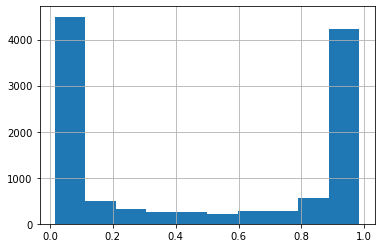

In [28]:
submission['Pred'].hist();

In [27]:
submission.to_csv('submission_lgb_xgb_ensemble.csv', index=False)

# Reference
- https://www.kaggle.com/khoongweihao/ncaam2020-xgboost-lightgbm-k-fold-baseline